# NLP con grafos

In [ ]:
from neo4j import GraphDatabase
from tabulate import tabulate
from graphviz import Digraph

In [ ]:
graph_connection = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "password"))

### ¿Cuáles son las palabras que más conexiones reciben?

In [9]:
most_connections = """
MATCH (n:Word)<-[r:NEXT]-(m:Word)
RETURN n.name AS name, r.count AS count
ORDER BY r.count DESC
LIMIT 5
"""

with graph_connection.session() as session:
    result = session.run(most_connections)
    table = [(r["name"], r["count"]) for r in result]
    print(tabulate(table, headers=["Word", "Count"]))

Word      Count
------  -------
amen         12
tipo          4
tiempo        3
cantar        3
tiene         3


### ¿Cuáles son los pares más frecuentes?

In [10]:
word_pairs = """
MATCH (w1:Word)-[r:NEXT]->(w2:Word)
RETURN [w1.name, w2.name] AS pairs, r.count AS count
ORDER BY r.count DESC
LIMIT 5
"""

with graph_connection.session() as session:
    result = session.run(word_pairs)
    table = [(r["pairs"], r["count"]) for r in result]
    print(tabulate(table, headers=["Pairs", "Count"]))

Pairs                 Count
------------------  -------
['amen', 'amen']         12
['este', 'tipo']          4
['pero', 'tiene']         3
['para', 'cantar']        3
['este', 'país']          3


In [11]:
word_pairs = """
MATCH (w1:Word)-[r:NEXT]->(w2:Word)
WHERE w1.name <> w2.name
RETURN [w1.name, w2.name] AS pairs, r.count AS count
ORDER BY r.count DESC
LIMIT 5
"""

with graph_connection.session() as session:
    result = session.run(word_pairs)
    table = [(r["pairs"], r["count"]) for r in result]
    print(tabulate(table, headers=["Pairs", "Count"]))

Pairs                 Count
------------------  -------
['este', 'tipo']          4
['para', 'cantar']        3
['pero', 'tiene']         3
['hace', 'meses']         3
['este', 'país']          3


###  Contextualizar palabras

In [12]:
word_left_context = """
MATCH (w1:Word {name: "amen"})
MATCH (w2:Word)-[r:NEXT]->(w1)
RETURN w2.name AS prev, w1.name AS word, r.count AS count
ORDER BY r.count DESC
"""

word_right_context = """
MATCH (w1:Word {name: "amen"})
MATCH (w2:Word)<-[r:NEXT]-(w1)
RETURN w2.name AS next, w1.name AS word, r.count AS count
ORDER BY r.count DESC
"""

with graph_connection.session() as session:
    result = session.run(word_left_context)    
    left_table = [(r["prev"], r["word"], r["count"]) for r in result]
    result = session.run(word_right_context)
    right_table = [(r["next"], r["word"], r["count"]) for r in result]
    print(tabulate(left_table, headers=["Previous Word", "Word", "Count"]))
    print()
    print(tabulate(right_table, headers=["Next Word", "Word", "Count"]))


Previous Word    Word      Count
---------------  ------  -------
amen             amen         12
recontra         amen          2
pous             amen          1

Next Word    Word      Count
-----------  ------  -------
amen         amen         12
ijue         amen          1


### Generar resúmenes

In [13]:
summarize = """
MATCH p=(:Word)-[:NEXT*1..4]->(:Word) WITH p
WITH reduce(s = 0, x IN relationships(p) | s + x.count) AS total, p
WITH nodes(p) AS text, 1.0*total/size(nodes(p)) AS weight
RETURN extract(x IN text | x.name) AS phrase, weight 
ORDER BY weight DESC LIMIT 10;
"""

with graph_connection.session() as session:
    result = session.run(summarize)    
    table = [(r["phrase"], r["weight"]) for r in result]
    print(tabulate(table, headers=["Phrase", "Weight"]))

Phrase                                                   Weight
-----------------------------------------------------  --------
['amen', 'amen']                                        6
['recontra', 'amen', 'amen']                            4.66667
['amen', 'amen', 'ijue']                                4.33333
['pous', 'amen', 'amen']                                4.33333
['multicolores', 'recontra', 'amen', 'amen']            4
['amen', 'amen', 'ijue', 'siete']                       3.75
['recontra', 'amen', 'amen', 'ijue']                    3.75
['siete', 'multicolores', 'recontra', 'amen', 'amen']   3.6
['mamaderus', 'pous', 'amen', 'amen']                   3.5
['pous', 'amen', 'amen', 'ijue']                        3.5


### Generar nuevos textos

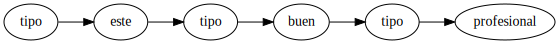

In [15]:
random_walk = """
MATCH (w:Word {{name: '{word}'}})
CALL algo.randomWalk.stream(id(w), 5, 1)
YIELD nodeIds
UNWIND nodeIds AS nodeId
RETURN algo.asNode(nodeId).name AS word
"""

def generate_random_comment(word):
    with graph_connection.session() as session:
        result = session.run(random_walk.format(word=word))
        words = [r["word"] for r in result]
        dot = Digraph(graph_attr={'rankdir':'LR'}, comment='Random Comment')
        words_length = len(words)

        for ix, word in enumerate(words):
            dot.node(word + str(ix), word)
                
        for ix, word in enumerate(words):
            if ix < words_length - 1:
                dot.edge(word + str(ix), words[ix + 1] + str(ix + 1))

        display(dot)

generate_random_comment("tipo")